In [1]:
# Imports
import torch
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import pygame
import random
import tqdm

In [2]:
# DQN model which takes in the state as an input and outputs predicted q values for every possible action
class DQN(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        # Add your architecture parameters here
        # You can use nn.Functional
        # Remember that the input is of size batch_size x state_space
        # and the output is of size batch_size x action_space (ulta ho sakta hai dekh lo)
        # TODO: Add code here
        
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/state_space), size=(state_space, 16)), dtype=torch.float))
        self.b1 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/state_space), size=(1, 16)), dtype=torch.float))

        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/16), size=(16, 8)), dtype=torch.float))
        self.b2 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/16), size=(1, 8)), dtype=torch.float))
        
        self.w3 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/8), size=(8, action_space)), dtype=torch.float))
        self.b3 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/8), size=(1, action_space)), dtype=torch.float))

        self.activation = torch.nn.ReLU(inplace=True)
        self.norm = torch.nn.BatchNorm1d(1)

    def forward(self, input):
        # TODO: Complete based on your implementation
        if np.ndim(input) == 1:
            input = torch.tensor(input, dtype=torch.float).unsqueeze(dim=0)
        else:
            input = torch.tensor(input, dtype=torch.float)

        input[:, 0] /= 4.8
        input[:, 1] /= 3.5
        input[:, 2] /= 12
        input[:, 3] /= 3
        # input = self.norm(input)
        
        input = torch.matmul(input, self.w1) + self.b1
        self.activation(input)

        input = torch.matmul(input, self.w2) + self.b2
        self.activation(input)
        
        input = torch.matmul(input, self.w3) + self.b3

        return input
    


In [3]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class ExperienceBuffer:
    def __init__(self, capacity):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 4), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 4), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 


In [4]:
def plot_progress(results):
    # plt.plot(np.convolve(results, np.ones(1)/1))
    plt.plot(np.convolve(results, np.ones(50)/50, 'valid'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    print(f"Best run: {max(results)}, at episode: {np.argmax(results)+1}")
    plt.scatter(np.argmax(results), 10, color='orange', s=100, zorder=5)

In [5]:
# TODO: Implement training logic for Snake Game here

import copy

def train(model, epoch=1000, gamm=0.99, rend=False, lrate = 0.001, epsi = 1):

    env = gym.make("CartPole-v1", render_mode="human" if rend else None)

    q_net = model
    target_net = copy.deepcopy(q_net)

    replay_buffer = ExperienceBuffer(10000)
    # temp_buffer = []

    epochs = epoch
    epsilon = epsi
    batch_size = 64
    gamma = gamm

    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=lrate)

    results = np.zeros(epochs)
    epsilons = np.zeros(epochs)

    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        action = np.random.randint(0, 2)

        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _ = env.step(int(action))
            
            # if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
            replay_buffer.push(state, action, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon:
                action = np.random.randint(0, 2)
                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    action = np.argmax(q_net(next_state))
                greedy = False


            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            # action = next_action

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()


            # updating target net
            if steps_till_update == 100:
            # if steps_till_update == max(i//5, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if total_reward >= 500:
                done = True

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.1:
            epsilon = max(0.1, 1-i*0.9/(epoch/2))

        results[i] = total_reward
        epsilons[i] = epsilon
        total_reward = 0

    env.close()
    return results, epsilons


In [6]:
def evaluate_cartpole_model(model, episodes=10, render=True, print_qvals = False):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []
    velocities = []
    ang_velocities = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state)
                if print_qvals:
                    print("q vals", q_values)
                action = torch.argmax(q_values, dim=1).item()

            obs, reward, done, _, _ = env.step(action)
            # print(f"velocity: {obs[1]}")
            # velocities.append(obs[1])
            # ang_velocities.append(obs[3])
            total_reward += reward

            if total_reward >= 10000:
                done = True


            if render:
                env.render()

        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")
        # plt.plot(velocities)
        # plt.plot(ang_velocities)
        # plt.show()
        velocities = []

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

Try 1 -- using the recommended hyperparameters

steps_till_update == 100<br>
loss = MSE <br>
Epsilon 1 to 0.1 linearly in 500 epoch <br>
batch size = 64 <br>
10k buffer <br>
4-16-8-2 dense NN <br>

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_33272\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [04:43<00:00,  3.52it/s]

Best run: 500.0, at episode: 563
Best run: 500.0, at episode: 525
Best run: 500.0, at episode: 429


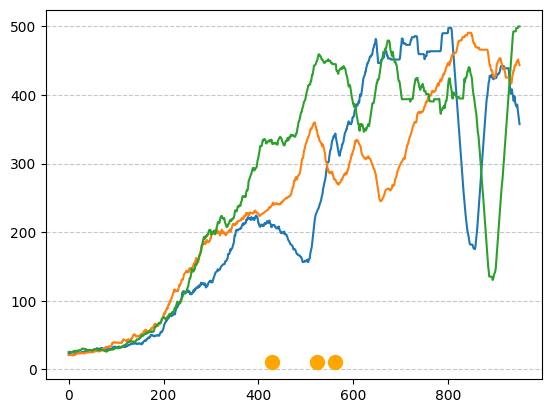

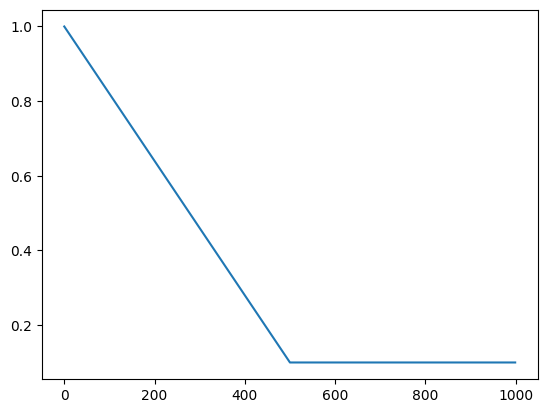

In [22]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001, epsi=1)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001, epsi=1)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001, epsi=1)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

greedy performance <br>
10,000+ every run (did not test higher)

Try 2 <br>
lr = 3e-4


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_33272\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [02:33<00:00,  6.52it/s]


Episode 1: Reward = 191.0
Episode 2: Reward = 214.0
Episode 3: Reward = 170.0
Episode 4: Reward = 192.0
Episode 5: Reward = 160.0
Episode 6: Reward = 161.0
Episode 7: Reward = 170.0
Episode 8: Reward = 150.0
Episode 9: Reward = 163.0
Episode 10: Reward = 201.0
Average reward over 10 episodes: 177.2


100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


Episode 1: Reward = 10000.0
Episode 2: Reward = 10000.0
Episode 3: Reward = 10000.0
Episode 4: Reward = 10000.0
Episode 5: Reward = 10000.0
Episode 6: Reward = 10000.0
Episode 7: Reward = 10000.0
Episode 8: Reward = 10000.0
Episode 9: Reward = 10000.0
Episode 10: Reward = 10000.0
Average reward over 10 episodes: 10000.0


100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]

Episode 1: Reward = 12.0
Episode 2: Reward = 14.0
Episode 3: Reward = 11.0
Episode 4: Reward = 13.0
Episode 5: Reward = 12.0
Episode 6: Reward = 12.0
Episode 7: Reward = 14.0
Episode 8: Reward = 13.0
Episode 9: Reward = 15.0
Episode 10: Reward = 15.0
Average reward over 10 episodes: 13.1
Best run: 500.0, at episode: 483
Best run: 500.0, at episode: 518
Best run: 500.0, at episode: 511


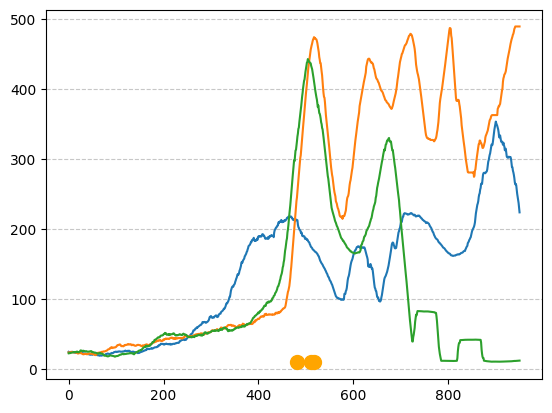

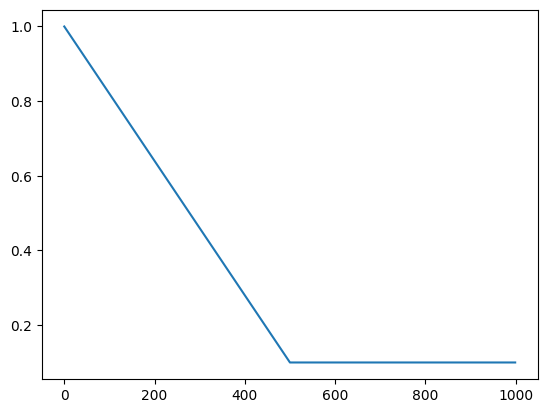

In [34]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

Try - 3 <br>
lr = 3e-3

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_33272\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


Episode 1: Reward = 108.0
Episode 2: Reward = 113.0
Episode 3: Reward = 97.0
Episode 4: Reward = 103.0
Episode 5: Reward = 117.0
Episode 6: Reward = 105.0
Episode 7: Reward = 115.0
Episode 8: Reward = 108.0
Episode 9: Reward = 115.0
Episode 10: Reward = 115.0
Average reward over 10 episodes: 109.6


100%|██████████| 1000/1000 [03:52<00:00,  4.29it/s]


Episode 1: Reward = 32.0
Episode 2: Reward = 42.0
Episode 3: Reward = 33.0
Episode 4: Reward = 32.0
Episode 5: Reward = 74.0
Episode 6: Reward = 36.0
Episode 7: Reward = 64.0
Episode 8: Reward = 58.0
Episode 9: Reward = 64.0
Episode 10: Reward = 54.0
Average reward over 10 episodes: 48.9


100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]


Episode 1: Reward = 10000.0
Episode 2: Reward = 10000.0
Episode 3: Reward = 10000.0
Episode 4: Reward = 10000.0
Episode 5: Reward = 10000.0
Episode 6: Reward = 10000.0
Episode 7: Reward = 10000.0
Episode 8: Reward = 10000.0
Episode 9: Reward = 10000.0
Episode 10: Reward = 10000.0
Average reward over 10 episodes: 10000.0
Best run: 500.0, at episode: 603
Best run: 500.0, at episode: 430
Best run: 500.0, at episode: 380


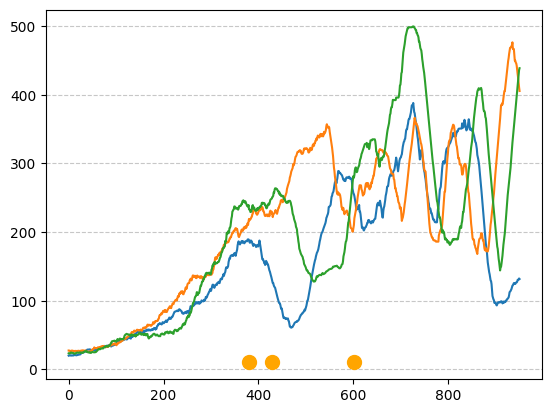

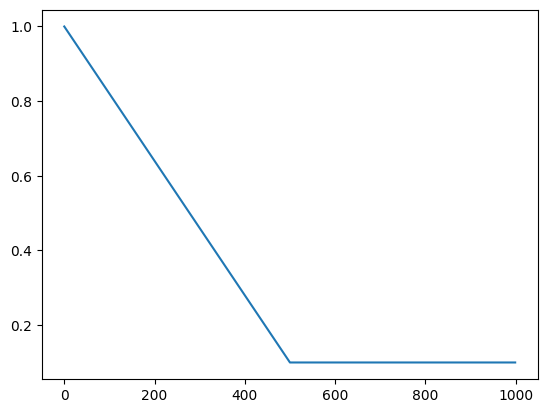

In [33]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.003, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

#### Trying with lower number of epochs

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_33272\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Episode 1: Reward = 444.0
Episode 2: Reward = 446.0
Episode 3: Reward = 438.0
Episode 4: Reward = 493.0
Episode 5: Reward = 465.0
Episode 6: Reward = 459.0
Episode 7: Reward = 488.0
Episode 8: Reward = 466.0
Episode 9: Reward = 474.0
Episode 10: Reward = 508.0
Average reward over 10 episodes: 468.1


100%|██████████| 500/500 [01:37<00:00,  5.13it/s]


Episode 1: Reward = 210.0
Episode 2: Reward = 243.0
Episode 3: Reward = 271.0
Episode 4: Reward = 243.0
Episode 5: Reward = 254.0
Episode 6: Reward = 297.0
Episode 7: Reward = 331.0
Episode 8: Reward = 229.0
Episode 9: Reward = 224.0
Episode 10: Reward = 252.0
Average reward over 10 episodes: 255.4


100%|██████████| 500/500 [01:35<00:00,  5.25it/s]


Episode 1: Reward = 10000.0
Episode 2: Reward = 10000.0
Episode 3: Reward = 10000.0
Episode 4: Reward = 10000.0
Episode 5: Reward = 10000.0
Episode 6: Reward = 10000.0
Episode 7: Reward = 10000.0
Episode 8: Reward = 10000.0
Episode 9: Reward = 10000.0
Episode 10: Reward = 10000.0
Average reward over 10 episodes: 10000.0
Best run: 500.0, at episode: 194
Best run: 500.0, at episode: 245
Best run: 500.0, at episode: 259


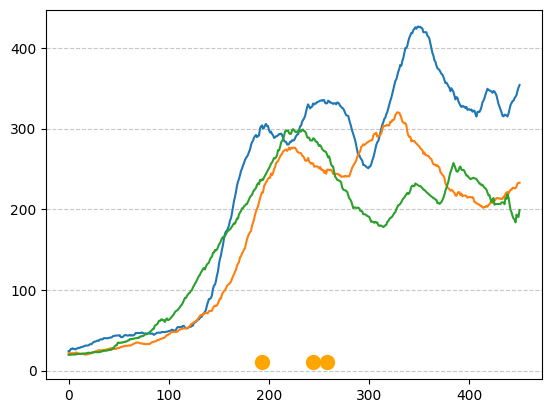

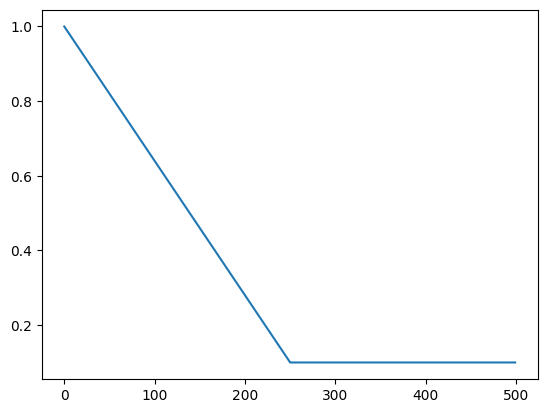

In [42]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_11504\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Episode 1: Reward = 342.0
Episode 2: Reward = 559.0
Episode 3: Reward = 373.0
Episode 4: Reward = 332.0
Episode 5: Reward = 1296.0
Episode 6: Reward = 447.0
Episode 7: Reward = 428.0
Episode 8: Reward = 515.0
Episode 9: Reward = 425.0
Episode 10: Reward = 424.0
Average reward over 10 episodes: 514.1


100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


Episode 1: Reward = 812.0
Episode 2: Reward = 417.0
Episode 3: Reward = 313.0
Episode 4: Reward = 434.0
Episode 5: Reward = 408.0
Episode 6: Reward = 10000.0
Episode 7: Reward = 10000.0
Episode 8: Reward = 365.0
Episode 9: Reward = 407.0
Episode 10: Reward = 704.0
Average reward over 10 episodes: 2386.0


100%|██████████| 500/500 [01:57<00:00,  4.27it/s]


Episode 1: Reward = 277.0
Episode 2: Reward = 266.0
Episode 3: Reward = 249.0
Episode 4: Reward = 286.0
Episode 5: Reward = 293.0
Episode 6: Reward = 312.0
Episode 7: Reward = 264.0
Episode 8: Reward = 337.0
Episode 9: Reward = 298.0
Episode 10: Reward = 281.0
Average reward over 10 episodes: 286.3
Best run: 500.0, at episode: 203
Best run: 500.0, at episode: 187
Best run: 500.0, at episode: 280


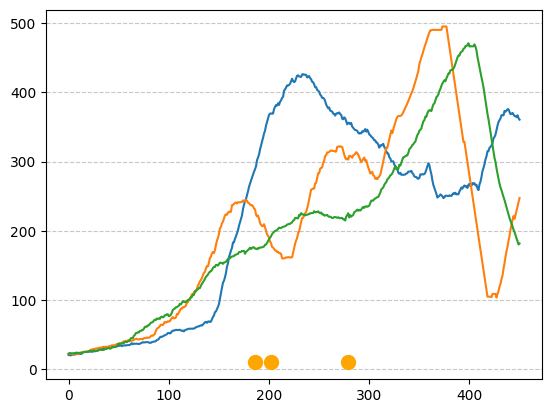

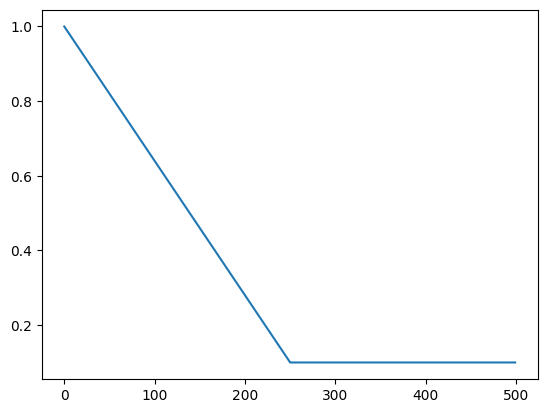

In [7]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=500, gamm=0.99, lrate=0.001, epsi=1)
evaluate_cartpole_model(model, print_qvals=False, render=False, episodes=10)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_29176\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [01:41<00:00,  9.88it/s]

Best run: 500.0, at episode: 762
Best run: 500.0, at episode: 747
Best run: 473.0, at episode: 858


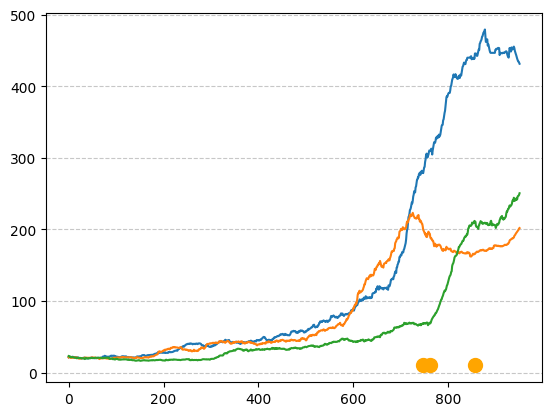

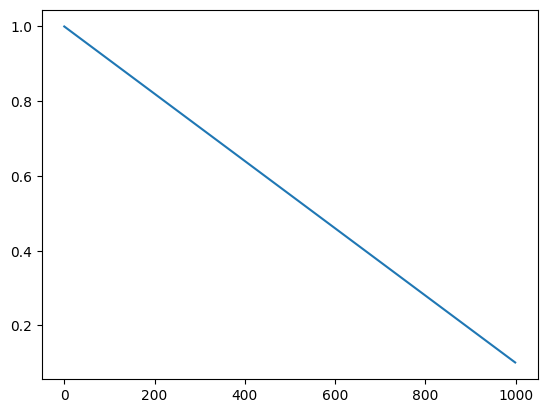

In [89]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

q value ~ 70 - 90

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_29176\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]

Best run: 500.0, at episode: 638
Best run: 500.0, at episode: 752
Best run: 500.0, at episode: 730


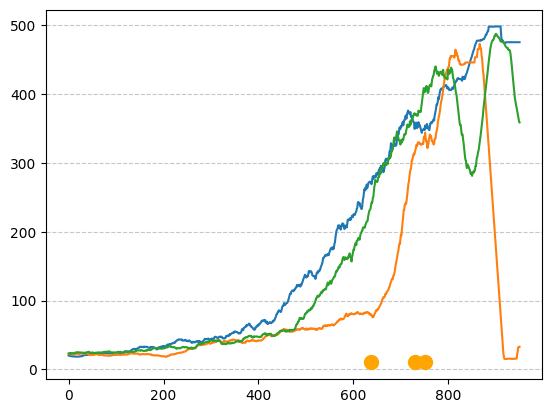

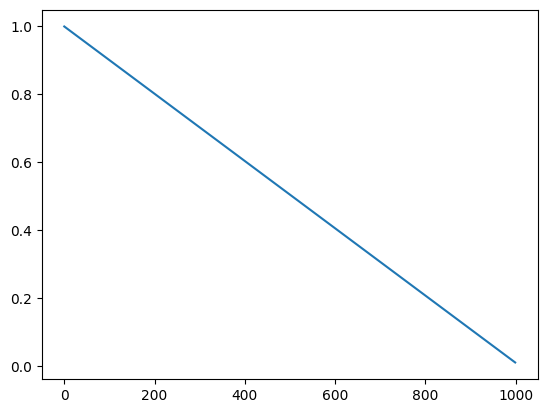

In [70]:
model = DQN(4, 2)
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model = DQN(4, 2)
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model = DQN(4, 2)
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

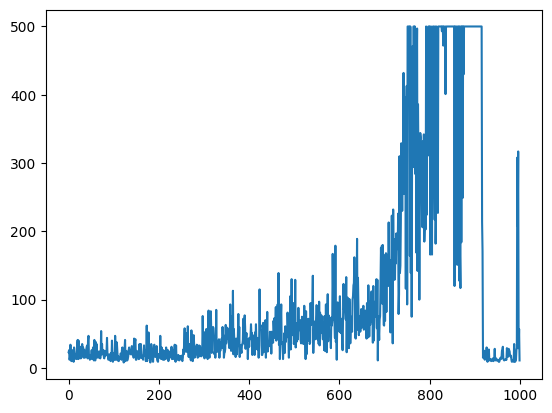

In [75]:
plt.plot(results1_2)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_29176\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]

Best run: 5000.0, at episode: 862
Best run: 472.0, at episode: 843
Best run: 2182.0, at episode: 844


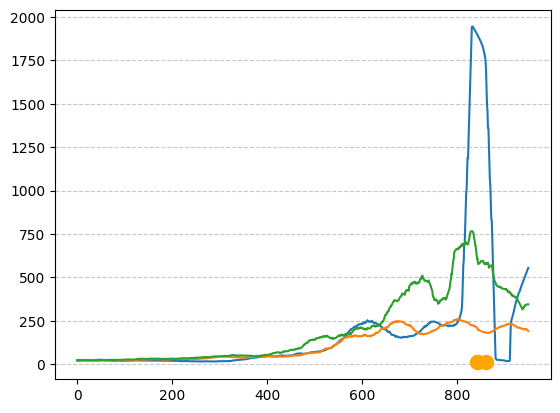

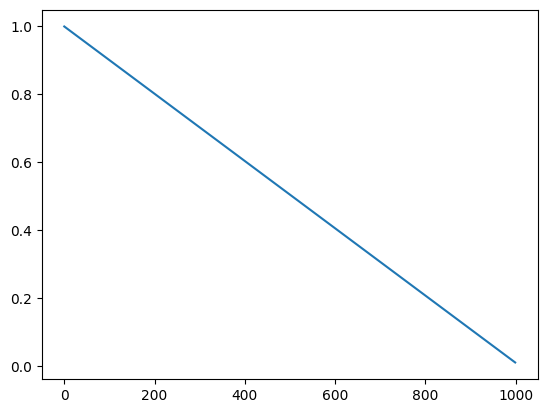

In [ ]:
model1_1 = DQN(4, 2)
results1_1, epsilons1 = train(model1_1, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model1_2 = DQN(4, 2)
results1_2, epsilons1 = train(model1_2, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model1_3 = DQN(4, 2)
results1_3, epsilons1 = train(model1_3, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_29176\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]

Best run: 740.0, at episode: 805
Best run: 2983.0, at episode: 994
Best run: 421.0, at episode: 858


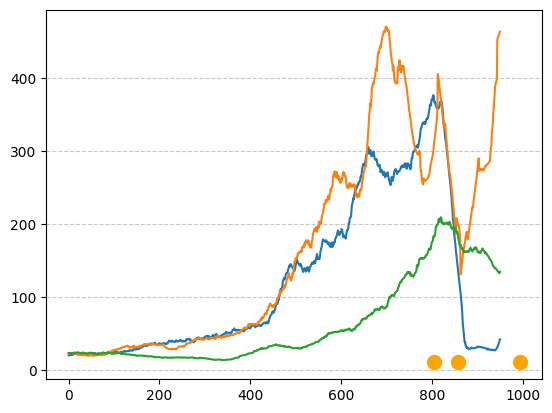

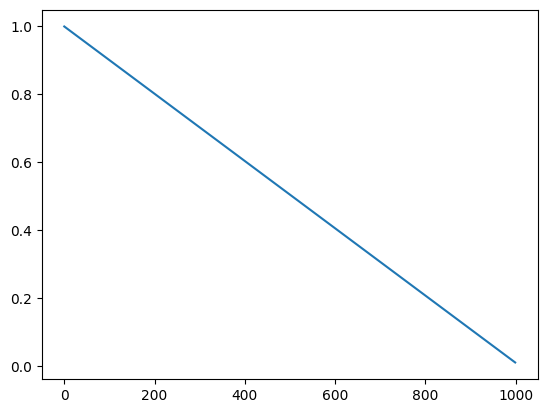

In [82]:
model1_1 = DQN(4, 2)
results1_1, epsilons1 = train(model1_1, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model1_2 = DQN(4, 2)
results1_2, epsilons1 = train(model1_2, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
model1_3 = DQN(4, 2)
results1_3, epsilons1 = train(model1_3, epoch=1000, gamm=0.99, lrate=0.0003, epsi=1)
plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

In [37]:
evaluate_cartpole_model(model, print_qvals=True, render=False, episodes=10)

q vals tensor([[109.7972, 113.3669]])
q vals tensor([[109.0116, 111.8113]])
q vals tensor([[108.2001, 110.2069]])
q vals tensor([[107.3475, 108.5272]])
q vals tensor([[106.4384, 106.7453]])
q vals tensor([[105.4575, 104.8349]])
q vals tensor([[106.1058, 106.1396]])
q vals tensor([[104.9960, 104.0054]])
q vals tensor([[105.5016, 105.0631]])
q vals tensor([[105.9509, 106.0276]])
q vals tensor([[104.6811, 103.6230]])
q vals tensor([[104.9961, 104.3585]])
q vals tensor([[105.2574, 105.0067]])
q vals tensor([[105.4767, 105.5889]])
Episode 1: Reward = 14.0
q vals tensor([[109.4623, 113.1813]])
q vals tensor([[108.5207, 111.3430]])
q vals tensor([[107.5483, 109.4490]])
q vals tensor([[106.5300, 107.4727]])
q vals tensor([[105.4505, 105.3874]])
q vals tensor([[105.9987, 106.5158]])
q vals tensor([[104.8108, 104.2445]])
q vals tensor([[105.2277, 105.1478]])
q vals tensor([[105.5935, 105.9675]])
q vals tensor([[104.2694, 103.4701]])
q vals tensor([[104.5126, 104.0826]])
Episode 2: Reward = 11.0


C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_33272\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
